In [38]:
import geopandas as gpd
import tempun
import matplotlib.pyplot as plt
import pickle

In [2]:
LIST = gpd.read_parquet("../data/large_data/LIST_v0-2.parquet")

In [3]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=5000)

In [4]:
medsea = gpd.read_file("https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:iho&outputformat=json&filter=%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3314%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3315%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3322%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3324%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3346%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3351%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3363%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3386%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4279%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4280%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E", driver="GeoJSON")
medsea = medsea.to_crs(3035)
medsea_merged = medsea.unary_union
medsea_merged_buffer = medsea_merged.buffer(distance=5000)

In [5]:
import pyproj
from shapely.ops import transform

project = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:3035'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # destination coordinate system

# g1 is a shapley Polygon
pleiades_regions_merged_buffer_4326 = transform(project.transform, pleiades_regions_merged_buffer)
medsea_merged_buffer_4326 = transform(project.transform, medsea_merged_buffer)  # apply projection

/Users/kasev/Projects/LIRE_ETL/lire_venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kasev/Projects/LIRE_ETL/lire_venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
%%time
withinRE = (LIST.within(pleiades_regions_merged_buffer_4326)) | (LIST.within(medsea_merged_buffer_4326))

CPU times: user 36min 45s, sys: 46.2 s, total: 37min 32s
Wall time: 37min 50s


In [10]:
withinRE.sum()

497360

In [14]:
LIST["withinRE?"] = withinRE

In [24]:
LIRE = LIST[
    #(LIST["geotemporal?"])
     (LIST["withinRE?"])
    & ((LIST["not_after"]>=-50)
    | (LIST["not_before"]<=350))]

In [25]:
len(LIRE)

187329

In [26]:
print(LIRE["EDH-ID"].isnull().sum())
print(LIRE["EDH-ID"].notnull().sum())


138497
48832


In [27]:
LIST["EDH-ID"].notnull().sum()

79899

In [28]:
LIRE_1 = gpd.read_parquet("/Users/kasev/Projects/associations/data/LIRE_contexts.parquet")
print(LIRE_1["EDH-ID"].isnull().sum())
print(LIRE_1["EDH-ID"].notnull().sum())

83482
52708


<AxesSubplot: >

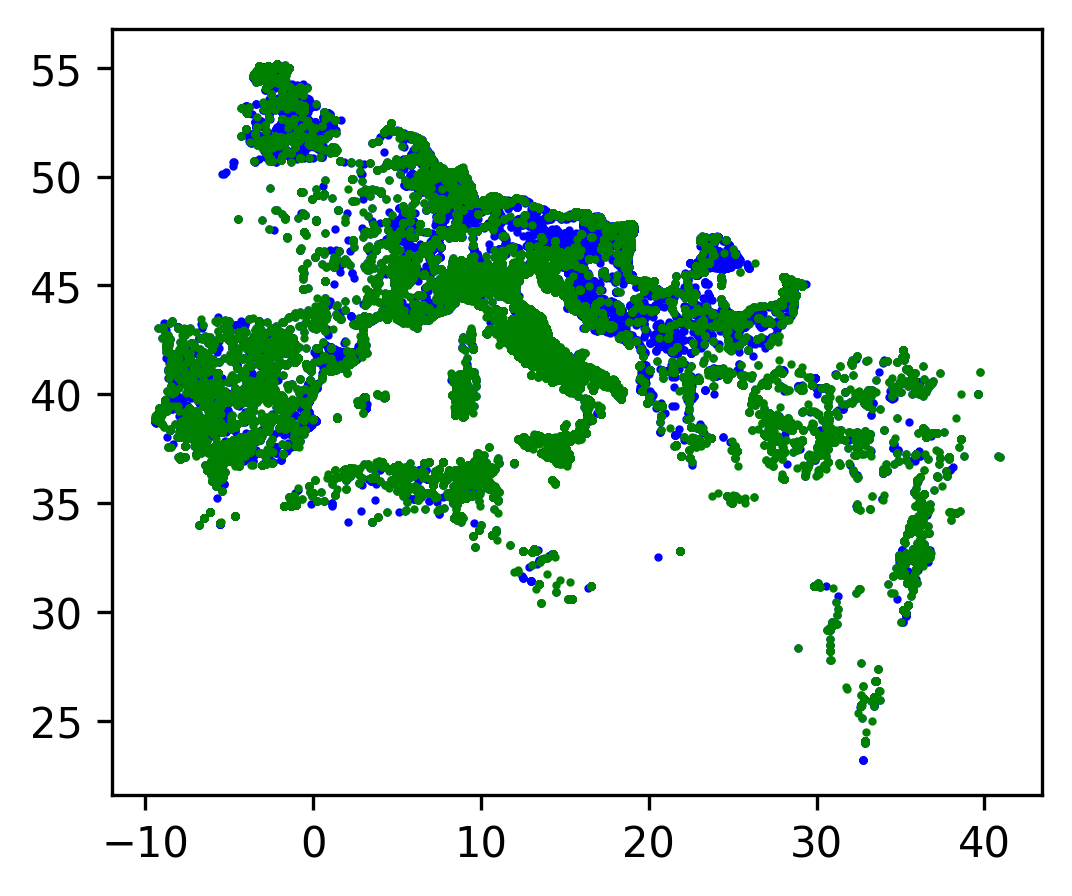

In [29]:
fig, ax = plt.subplots(1,1, figsize=(4,6), dpi=300)
LIRE_1.plot(ax=ax, markersize=1, color="blue")
LIRE.plot(ax=ax, markersize=1, color="green")

In [32]:
missing = list(set(LIRE_1["EDH-ID"]).difference(set(LIRE["EDH-ID"])))
len(missing)

8133

In [40]:
with open("../data/missing_EDH.pickle", "wb") as f:
    pickle.dump(missing, f)

In [36]:
LIRE_1[LIRE_1["EDH-ID"].isin(missing)]

,EDCS-ID,publication,province,place,notes_dating,notes_references,notes_comments,inscription,inscription_stripped_final,Links,...,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Alea / Tegea,,,,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,http://db.edcs.eu/epigr/partner.php?s_language...,...,False,97,"[22.417226, 37.427653]",471.49,55,"[22.405305, 37.642803]",23430.85,73,"[22.336587, 37.462155]",7876.09
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Andros,,,,Pro salute Imp(eratoris) Caesari(s) / L(uci) S...,Pro salute Imp(eratoris) Caesari(s) / L(uci) S...,http://db.edcs.eu/epigr/partner.php?s_language...,...,False,14,"[23.726559, 37.971119]",98716.19,28,"[25.267249, 37.398611]",60414.04,47,"[24.34625, 37.633122]",47547.59
14,EDCS-26001122,"CIL 03, 14203,14 = CIL 01, 02228 (p 1096) = IG...",Achaia,Argos,,,,[3] l(iberta) Hiluria [3] //,[3] l(iberta) Hiluria [3] //,http://db.edcs.eu/epigr/partner.php?s_language...,...,False,13,"[22.719769, 37.631278]",1215.27,85,"[22.641069, 37.831664]",23469.88,36,"[23.132244, 37.626573]",35223.47
20,EDCS-09700748,"SEG-25, 00370 = ILGR 00089 = AE 1971, 00443",Achaia,Argos,,,,M(arcus) Perperna / Hymnus //,M(arcus) Perperna / Hymnus //,http://db.edcs.eu/epigr/partner.php?s_language...,...,False,13,"[22.719769, 37.631278]",1215.27,85,"[22.641069, 37.831664]",23469.88,36,"[23.132244, 37.626573]",35223.47
21,EDCS-12400466,"AE 1998, 01231",Achaia,Arta / Ambracia,,,,PHFRI,PHFRI,http://db.edcs.eu/epigr/partner.php?s_language...,...,False,65,"[20.733395, 39.026505]",26392.16,7,"[20.987, 39.158]",323.89,106,"[20.980902, 38.854918]",33937.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52678,None,None,None,None,None,None,None,None,None,None,...,True,602,"[4.299444, 46.951667]",93469.26,664,"[5.33411, 47.862974]",63034.12,612,"[5.0428, 47.2906]",28636.45
52680,None,None,None,None,None,None,None,None,None,None,...,True,602,"[4.299444, 46.951667]",80544.68,664,"[5.33411, 47.862974]",58853.07,612,"[5.0428, 47.2906]",12783.54
52682,None,None,None,None,None,None,None,None,None,None,...,True,602,"[4.299444, 46.951667]",74454.35,664,"[5.33411, 47.862974]",73798.82,612,"[5.0428, 47.2906]",15674.73
52697,None,None,None,None,None,None,None,None,None,None,...,True,602,"[4.299444, 46.951667]",430110.17,673,"[8.277769, 49.993057]",28472.20,665,"[8.238789, 50.084337]",38917.83
